 # Topic Modelling using LDA

## What is Topic Modeling

Topic modeling is the idea that a collection of text can be represented by latent topics. Representing documents as topics can be useful for text-mining, feature reduction, clustering and document generation. Running a 'Topic Model' on data returns a collection of topics, where each topic is an unlabeled cluster of words that characterize a set of documents. Topic modeling is an unsupervised approach, meaning the input data does not have to be labeled.


More about topic models: https://mimno.infosci.cornell.edu/papers/2017_fntir_tm_applications.pdf

## Loading Data and Building a Dictionary

The documents used for the LDA model are represented by abstracts from various research papers provided from https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles. 

Each paper belongs to one of six different research fields.

Step one of building the model is to build a word dictionary with relevant words for the underlying topics of the documents. We'll also transform the text data into a format more suitable as input for the model in the form of bags of words.

In [26]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import scipy.special as sp
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import timeit


from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

LOAD_PARAMS = True
train = False
K = 10
VI_ITERATIONS = 250
EM_ITERATIONS = 15
LOW_BOUND = 25
UP_BOUND = 0.2
b_scale = 0.8
a_scale = 0.5
REDUCE_DATASET = False
REDUTION_SIZE= 400
model_path = "../input/lda-model"

data = pd.read_csv('../input/topic-modeling-for-research-articles/train.csv')
train_df = data[['ABSTRACT']]


### Analysing and processing the data

Let's start off by briefly analysing the data and the classes available to us.

[6013, 5618, 5206, 8594, 587, 249]


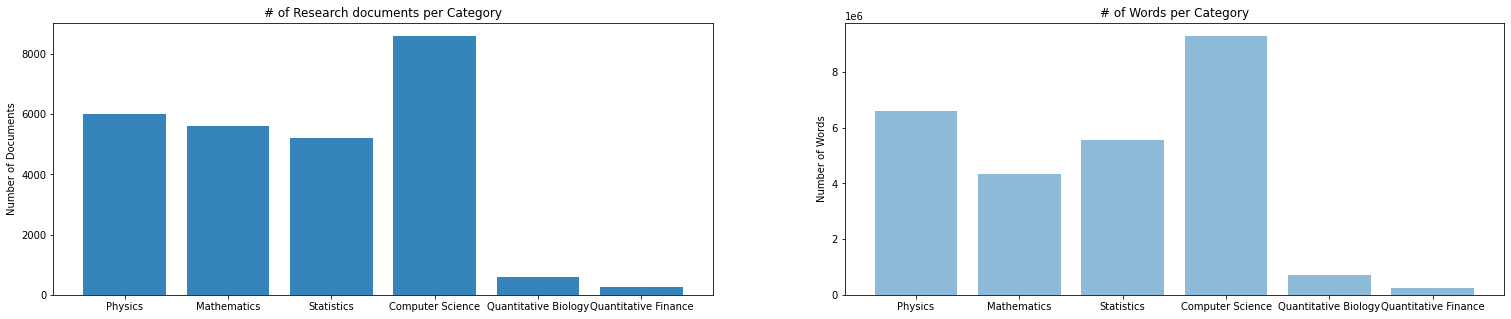

Amount of documents: 20972


In [27]:
classes = ['Physics','Mathematics','Statistics','Computer Science','Quantitative Biology','Quantitative Finance']
class_count = []
word_count = []
for c in classes:
    class_count.append(data[c].value_counts()[[1]][1])
    class_abstracts = data.where(data[c]==1)[['ABSTRACT']]
    word_count.append(pd.Series(class_abstracts.values.flatten()).str.len().sum())
print(class_count)


f, (ax1,ax2) = plt.subplots(1,2,figsize=(26,5))

ax1.bar(classes,class_count,align='center', alpha=0.9)
ax1.set_ylabel('Number of Documents')
ax2.bar(classes,word_count,align='center', alpha=0.5)
ax2.set_ylabel('Number of Words')
ax1.set_title('# of Research documents per Category')
ax2.set_title('# of Words per Category')

plt.show()
print("Amount of documents:", data.shape[0])


The bar charts shows the distribution of classes over the documents and how many words all documents from a class has. It becomes clear that the groud truth of the data is quite unbalanced as the quantitative biology and finance classes are lacking in both words and documents compared to the rest of the classes. As is usually the case with LDA, the amount of latent topics that might fit best for inference might not necessarily reflect the ground truth. We will look into how the model performs on a balanced and unbalanced dataset when it comes to topic modeling. For some of the experiments we are going to run the code on a reduced dataset as the computation time scales heavily with feature size. Another important note is that some documents are a mixture of ground true topics.

In [28]:
df = None
if REDUCE_DATASET:
    df = pd.DataFrame(columns=data.columns)
    for i,c in enumerate(classes):
        df = df.append(data.loc[data[c]==1][:REDUTION_SIZE]) #& ~df['ID'].isin(new_df['ID'])])
    df = df.drop_duplicates(subset='ID')

    class_count = []
    word_count = []
    for c in classes:
        class_count.append(df[c].value_counts()[[1]][1])
        class_abstracts = df.where(df[c]==1)[['ABSTRACT']]
        word_count.append(pd.Series(class_abstracts.values.flatten()).str.len().sum())

    f, (ax1,ax2) = plt.subplots(2,1,figsize=(30,10))
    ax1.bar(classes,class_count,align='center', alpha=0.9)
    ax1.set_ylabel('Number of Documents')
    ax2.bar(classes,word_count,align='center', alpha=0.5)
    ax2.set_ylabel('Number of Words')
    ax1.set_title('# of Research documents per Category')
    ax2.set_title('# of Words per Category')
    plt.show()

    print("Amount of documents:", df.shape[0])
else:
    df = data

The text has to be transformed into a format that is suitable as input to the model. For this problem we choose the **Bag of Words** format where each term and it's respective term frequency is represented as a vector.

The text for each document is **tokenized** using the ```simple_preprocess``` function from the gensim library which also lowercases and deaccents each individual word. Tokens are much easier to work with compared to a long string of text. It's important that the words used for the model have meaning to the context of the topics. Therefore, words that are common among all documents are filtered out using the **stopwords** list provided by the nltk corpus. Examples of stopwords are 'it, this, or, and'. Finally, a regex is applied to remove any unessecary special characters.

In [29]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

start = timeit.default_timer()

cachedStopWords = set(stopwords.words('english'))
def pre_process(text):
    tokens = simple_preprocess(text,deacc=True,min_len=3)
    text = [lemmatizer.lemmatize(re.sub('[^A-Za-z]+', ' ', token)) for token in tokens if not token in cachedStopWords]
    return text

df['BOW'] = df.apply(lambda row : pre_process(row['ABSTRACT']), axis = 1)

checkpoint = timeit.default_timer()

print("Pre-Processing finished in ", str(round(checkpoint-start,2)), "seconds")
word_frequencies = pd.Series([y for x in df['BOW'].values.flatten() for y in x]).value_counts()


Pre-Processing finished in  30.27 seconds


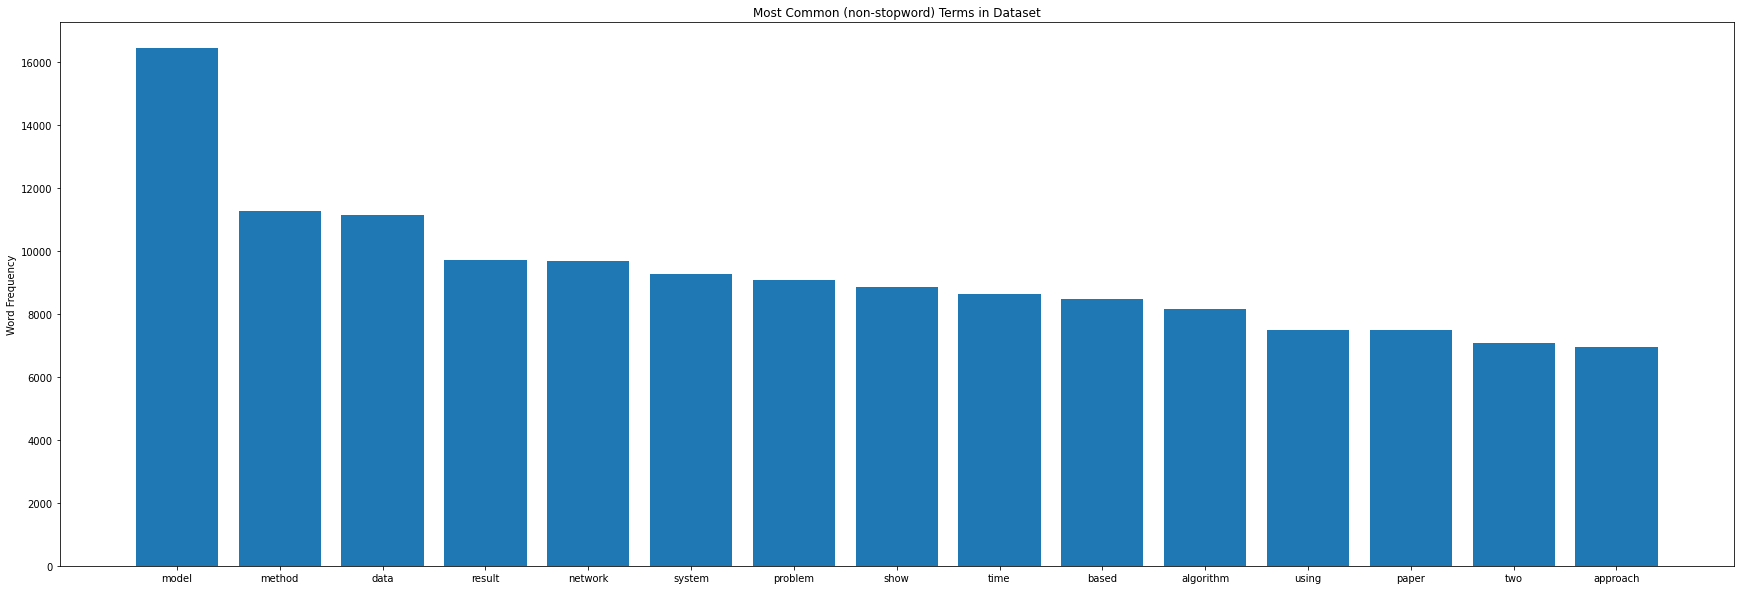

In [5]:
f, ax1 = plt.subplots(1,figsize=(30,10))
ax1.bar(word_frequencies.axes[0].tolist()[:15],word_frequencies.iloc[:15])
ax1.set_ylabel('Word Frequency')
ax1.set_title('Most Common (non-stopword) Terms in Dataset')
#ax1.imshow(WordCloud().fit_words(word_frequencies))
plt.show()


The barplot and the word cloud visualize the most frequent non-stopwords throughout the dataset. The most frequent words are definitely relevant to the research classes shown earlier, meaning we can move on to the next step.

Now it's time to create the dictionary using the bags of words. **The more words** included in the dictionary, **the longer training will take** for the LDA model to learn. For that reason, we should filted out words that are not especially relevant for many documents. This is done by **filtering out low frequency words**. Furthermore, words that are too frequent might also need to be filtered out as they are most likely relevant for all underlying topics, similarly to stopwords. By adding the filter, the amount of dictionary words were **reduced from 49380 down to 5310**. Reducing the size of the vocabulary speeds up the training process tremendously.

In [6]:
from gensim.corpora import Dictionary
dictionary = Dictionary()
if LOAD_PARAMS:
    dictionary = dictionary.load(model_path+'/dictionary')
    print("Loaded Dictionary of Size:",len(dictionary))
else:
    start = timeit.default_timer()
    dictionary = Dictionary(df['BOW'])
    print("Dictionary size without filtering:", len(dictionary))
    dictionary.filter_extremes(no_below=LOW_BOUND,no_above=UP_BOUND)
    end = timeit.default_timer()

    print("Dictionary size after filtering:", len(dictionary))

    print("Constructing Filtered Dictionary took", str(round(end-start,2)), "Seconds")
    dictionary.save("dictionary")

    # Corpus is the set of documents where each word corresponds to an index in the dictionary

corpus = [np.array(list(filter(lambda a: a != -1, dictionary.doc2idx(doc)))) for doc in df['BOW']]
V = len(dictionary)


Loaded Dictionary of Size: 5310


The dictionary is needed to **map word to indices** since we need numerical values when training.

## Latent Dirichlet Allocation

### An overview

LDA, or 'Latent Dirichlet Allocation' is a **probabilistic generative model** often used in the context of text. It's a 3-stage **hierarchial bayesian model**, meaning the parameters of the posterior distribution can be estimated through **Bayesian inference**.


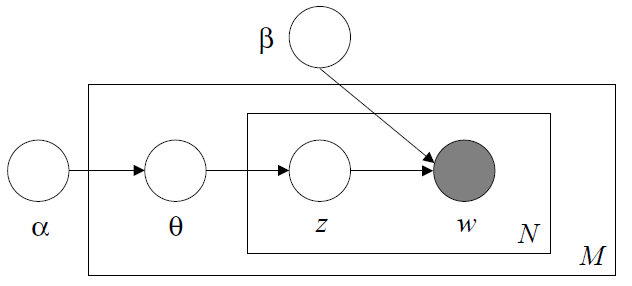.

The figure above is the **graphical model representation of LDA**. The innermost plate (N) represents words and the outer plate (M) represents documents.

+ $k$ - A predefined variable that decides the amount of latent topics.

+ $M$ - The amount of documents in the collection.
+ $N$ - The amount of words for a document.
+ $V$ - Vocabulary size.


+ **$\alpha$** - The **Dirichlet prior ($Dir(\alpha)$**) is parametrized by a vector $\alpha$ of length $k$. **$\alpha$** is known as the **concentration hyperparameter**.

+ $\theta_m$ - The **topic distribution** over $k$ topics for a document $m$. Sampled from $Dir(\alpha)$

+ **$z_{m,n}$** - a sampled topic from the multinomial topic distribution $\theta_m$ for the  $n$:th word in a specific document $m$.

+ **$w_{m,n}$** - The specific word in position $n$ in document $m$

+ $\beta$ - Parametrizes the **word distribution for each topic**. $\beta$ is a $k \times V$ matrix where each row of $\beta$ parametrizes a **Dirichlet prior ($Dir(\beta_k)$)**  modeling the word distribution **$\phi_i$** over a topic $k$. In other words, an element $\beta_{k,n} = P(w_{n}|z_k)$



Source:
https://ai.stanford.edu/~ang/papers/jair03-lda.pdf

### Training the Model

The training of the model is done through a **variational expectation-maximization** (EM) procedure. It's an iterative method where parameters of the statistical model are approximated. In this case, the focus is to maximize the family of lower bounds in the variational distribution of the model. We are looking to find the parameters that maximize the marginal log likelihood of the data, as shown below.

$\ell(\alpha, \beta)=\sum_{d=1}^{M} \log p\left(\mathbf{w}_{d} \mid \alpha, \beta\right)$

Each iteration of the EM procedure is made up of two steps, an expectation (E) step and a maximization (M) step. The E step will provide a lower bound on the log likelihood through variational inference which we will then maximize in the M step. The conditional $p(w_d|\alpha,\beta)$ is intractable which is why we use variational inference to find a tractable lower bound which is can then be easily maximized.

**Expectation (Step 1):**

The variational distribution is presented in [the original LDA paper][1] both graphically and as an equation as shown below,

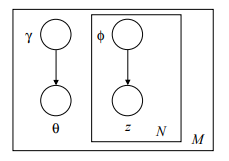

$q(\theta, \mathbf{z} \mid \gamma, \phi)=q(\theta \mid \gamma) \prod_{n=1}^{N} q\left(z_{n} \mid \phi_{n}\right)$

where $\gamma$ is a Dirichlet parameter and each $\phi_n$ is a free variational parameter.

The expectation step aims to optimize the values of the variational parameters for each document by minimizing the KL-divergence between the presented variational distribution and the true joint posterior of $\theta$ and $z$. I'm going to present the update functions without going through the trouble of deriving them. If you're interested in how they were derived, take a look in the original LDA paper.

$\phi_{n i} \propto \beta_{i w_{n}} \exp {\Psi\left(\gamma_{i}\right)-\Psi\left(\sum_{j=1}^{k} \gamma_{j}\right)}$

$\gamma_{i}=\alpha_{i}+\sum_{n=1}^{N} \phi_{n i}$


note that $\Psi$ is the digamma function.






[1]: https://ai.stanford.edu/~ang/papers/jair03-lda.pdf

In [7]:
# Phi initialized to row-uniform distribution
def initializeDoc(alpha, N, K):
    phi = np.ones((N,K)) / K
    gamma = alpha + N / K
    return phi, gamma

def VI(alpha, beta, N, doc, K, numIterations, gammaPrev):
    phi, gamma = initializeDoc(alpha, N, K)
    t = 0
    gammaPrev = gamma
    phiPrev = phi
    for t in range(numIterations):
        words = doc[np.arange(N)]
        expVec = np.exp(sp.digamma(gamma) - sp.digamma(np.sum(gamma)))
        if len(words) > 0:
            betaMat = beta[:, words]
            phi = betaMat.T * expVec + 1e-100
            phi = phi / np.expand_dims(np.sum(phi, axis=1), 1) # Normalize phi to avoid overflow since the update function is proportionate, not equals
            gamma = alpha + np.sum(phi, axis=0)
    return phi, gamma

**Maximization (Step 2):**

The Maximization step sets out to **maximize the lower bound** with respects to the Dirichlet parameters $\alpha$ and $\beta$ through ML-estimates.

$\beta_{i j} \propto \sum_{d=1}^{M} \sum_{n=1}^{N_{d}} \phi_{d n i}^{*} w_{d n^{*}}^{j}$

$\alpha_{\text {new }}=\alpha_{\text {old }}-\frac{g_{i}-c}{h_{i}}$


The parameter $\alpha$ is maximized through a Newton-Rhapson method which makes use of the Hessian matrix. The $\alpha$ update step is shown above. 

where

$c=\frac{\sum_{j=1}^{k} g_{j} / h_{j}}{z^{-1}+\sum_{j=1}^{k} h_{j}^{-1}}$,

$z=M \Psi^{\prime}\left(\sum_{k} \alpha_{k}\right)$

$g$ and $h$ are the gradient and Hessian matrix of the old $\alpha$ and $\Psi^{\prime}$ is the trigamma function.

By using derivations presented by [Minka][1] in conjunction with those presented by [Blei][2] in the original paper, we can derive the following hessian and gradient equations:

$g_{k}=M \Psi\left(\sum_{k} \alpha_{k}\right)-M \Psi\left(\alpha_{k}\right)+M \log \bar{\theta}_{k}$

$h_k = -M \Psi^{\prime}\left(\alpha_{k}\right)$

where $\bar{\theta}$ is the average proportionality of topic $k$ over all sampled documents from $Dir(\alpha)$. In other words, it's the expected value of the Dirichlet distribution for a specific topic $k$,

$ \log \bar{\theta}_{k}=\frac{1}{M} \sum_{i} \log \theta_{i k}$

$\log \left({\theta}_{k}\right)=E\left[\log \left(\theta_{k}\right)\right]=\Psi\left(\gamma_{k}\right)-\Psi\left(\sum_{i}^{M} \gamma_{i}\right)$

By plugging in all the values into the update functions, we can now calculate the the M-step.

Here is another useful source for the M-step update by [J. Huang][3]

[1]: [https://tminka.github.io/papers/dirichlet/minka-dirichlet.pdf]
[2]: [https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf]
[3]: [http://jonathan-huang.org/research/dirichlet/dirichlet.pdf]

In [8]:
import concurrent 
import sys
from multiprocessing import Pool, cpu_count

def hessian_inverse_gradient(alpha, M, K, gamma):
    alphaSum = np.sum(alpha)
    z = M * sp.polygamma(1, alphaSum)  # c

    hessian = np.zeros(K)
    gradient = np.zeros(K)

    gammaSumDigamma = sp.digamma(np.sum(gamma, axis=1))
    gammaSumDigamma = np.expand_dims(gammaSumDigamma, 1)  # (M, 1)
    extectedTheta = sp.digamma(gamma) - gammaSumDigamma  # (M, K)
    avgExtectedTheta = np.mean(extectedTheta, axis=0)  # (1, K)

    if alphaSum == 0:
        print("alpha:", alpha)
    for k in range(K):
        hessian[k] = -M * sp.polygamma(1, alpha[k])
        gradient[k] = M * (sp.digamma(alphaSum) - sp.digamma(alpha[k]) + avgExtectedTheta[k])
    inv_hessian = np.reciprocal(hessian)
    if z == 0:
        print("z:", z)

    c = np.sum(gradient * inv_hessian)
    c /= (np.sum(inv_hessian) + (1 / z))

    return (gradient - c) / hessian

def summing_over_beta(i,phi,beta_row,V,M):
    for j in range(V):
        betaSum = 0
        for d in range(M):
            idxs = np.where(corpus[d] == j)[0]
            if len(idxs) > 0:
                betaSum += np.sum(phi[d][:, i][idxs])
        beta_row[j] = betaSum
    return beta_row,i

def maximizationStep(corpus, V, alpha, beta, phi, K, gamma):
    M = len(corpus)
    alpha = alpha - hessian_inverse_gradient(alpha, M, K, gamma)
    with concurrent.futures.ProcessPoolExecutor(K) as executor:
        futures = [executor.submit(summing_over_beta,i,phi,beta[i],V,M) for i in range(K)]
        for f in concurrent.futures.as_completed(futures):    
            val,i = f.result()
            beta[i] = val
            
    return alpha, beta/beta.sum(axis=1, keepdims=True)


**Now let's run the model!**

In [32]:
def initAlpha(K,scale=a_scale):
    return np.ones((K))*scale

def initBeta(K,V,scale=b_scale):
    return np.random.dirichlet(np.ones(V)*scale,K)

def expectationMaximization(corpus, V,alpha,beta):
    #alpha, beta =initAlphaBeta(V, K)
    phi = None
    gamma = []
    phiPrev = None
    gammaPrev = None

    for i in range(EM_ITERATIONS):
        print("EM iteration:", i)
        phi = []
        gamma = [None for _ in range(len(corpus))]
        # E: VI
        timeTaken = timeit.default_timer()
        for idx, doc in enumerate(corpus):
            N = len(doc)
            phiDoc, gammaDoc = VI(alpha, beta, N, doc, K, VI_ITERATIONS, gamma[idx])
            phi.append(phiDoc)
            gamma[idx] = gammaDoc

        print("Time taken E:", timeit.default_timer() - timeTaken)
        timeTaken = timeit.default_timer()
        alpha, beta = maximizationStep(corpus, V, alpha, beta, phi, K, gamma)
        print("Time taken M:", timeit.default_timer() - timeTaken)
    return alpha,beta,phi,gamma

def estimateParams(vocab, corpus):
    V = len(vocab)
    alpha=initAlpha(K)
    beta=initBeta(K,V)
    a, b, phi, gamma = expectationMaximization(corpus, V,alpha,beta)
    return a, b, phi, gamma
        
# only estimate params if this is false, otherwise load old params

if LOAD_PARAMS:
    print("Loading parameters!")
    alpha = np.load(model_path+"/a.npy")
    beta = np.load(model_path+"/b.npy")
    phi = np.load(model_path+"/phi.npy", allow_pickle=True)
    gamma = np.load(model_path+"/gamma.npy")
    K = beta.shape[0]
    if train:
        alpha,beta,phi,gamma = expectationMaximization(corpus, V,alpha,beta)
        np.save("a", alpha)
        np.save("b", beta)
        np.save("phi", phi)
        np.save("gamma", gamma)
        dictionary.save("dictionary")
else:
    print("Estimating parameters!")
    alpha, beta, phi, gamma = estimateParams(dictionary, corpus)
    np.save("a", alpha)
    np.save("b",beta)
    np.save("phi", phi)
    np.save("gamma", gamma)

Loading parameters!


## Testing and Results

### Results


### Generative Powers

The model assumes that each word is generated by a random topic where the topic has been chosen from a topic distribution. 

The process of generating document using the model essentially goes like this:

1. Choose length of the document (**$N$**).
2. From **$Dir(\alpha)$**, sample **$\theta$**.
3. Do $N$ times: 
    3. From **$\theta$**, sample a topic **$z_n$**
    4. From $Dir(\beta_{z_n})$, sample a word **$w_n$.**
    

In [68]:
from termcolor import colored
colors = ['red','green','blue','yellow','magenta','cyan','brown','grey','yellow','olive']
avg_N = df['BOW'].apply(len).mean()
#1. Choose N
N = np.random.poisson(int(avg_N))
theta = np.random.dirichlet(alpha)
Z = np.random.choice(K,size=N,p=theta)
phis = np.array([np.random.dirichlet(phi) for phi in beta[Z]])
words = np.array([np.random.choice(V,size=1,p=phi)[0] for phi in phis])
print(' '.join([colored("Topic"+ str(i),c) for i,c in enumerate(colors[0:K])]))
print()
print(' '.join([colored(dictionary[w],colors[np.argmax(beta[:,w])]) for i,w in enumerate(words)]))


Topic0 Topic1 Topic2 Topic3 Topic4 Topic5

considered weight video knowledge tool competitive different non inspired performance horizon seek convergence deep autonomous distribution source magnetic doping translation spin relaxation joint proposed compared first updated implement valid monitor dft activity network new tool game following adaptive scratch calculate population sensitivity network slow computationally market aggregation analyst efficient constant key resulting meeting learning statistical convex source since vanishing matlab reduced deterministic algorithm title mobile black stage stock emerging structure popular without noise introduces communication biomedical demonstrated evaluate retrieval pivotal wireless dividing wavelet started different bit alignment liquid organic incomplete true game testing larger network


While the LDA model is a generative model, it doesn't really generate any useful documents (especially considering we removed stopwords and added lemmatization). The true power of the model lies in its topic modelling capabilities as it can identify underlying topics in the documents.



### Clustering on the full dataset

Lets explore the clustering performance of the method. By analyzing the $\beta$ matrix, we can identify the word distribution of each topic and analyze how the model classifies different documents into underlying topics. To find the words that characterize each topic, we extract the words corresponding to the highest probability in the $\beta$ matrix for a specified topic $k$. The results can be visualized as a list of words corresponding to each topic or as word clouds where the words that characterize a topic the most are shown in a larger font.

Note, the clustering experiments were conducted with the **number of topics $K = 6$ on the full dataset** in order to compare to the ground truth labels of the collection.

In [11]:
from math import floor
top_colors = ['Reds','Greens','Blues','Oranges','Purples', 'GnBu','copper','Greys','Wistia','summer']

def display_word_weighting(beta,dictionary,words_to_display=10,colors=top_colors):
    topic_amt = beta.shape[0]
    word_df = pd.DataFrame()
    fig,ax = plt.subplots(int(topic_amt/2),2,figsize=(30,30))
    for k in range(topic_amt):
        phi = np.random.dirichlet(beta[k])
        indices = beta[k].argsort()[-words_to_display:][::-1]
        words = []
        word_dist = []
        for i in indices:
            words.append(dictionary[i])
            word_dist.append(beta[k][i])
        word_df.insert(k,"Topic "+str(k),words)
        d = {w: f for w, f in
         zip([v for i,v in dictionary.items()],beta[k])}
        wordcloud = WordCloud(background_color='black', colormap=colors[k], prefer_horizontal=1)
        wordcloud.generate_from_frequencies(frequencies=d)
        ax[floor(k/2)][k%2].imshow(wordcloud)
        ax[floor(k/2)][k%2].axis('off')
        ax[floor(k/2)][k%2].set_title("Word Cloud for Topic: " + str(k))
    display(word_df)
    plt.show()



Topic 0       Topic 1      Topic 2   Topic 3      Topic 4     Topic 5
0         mass     algorithm        state     graph      network    equation
1         star  distribution        phase     space     learning     dynamic
2       galaxy      function        field     group         task    solution
3  observation      proposed         spin  function       neural      energy
4         high     parameter      quantum    mathbb        image     control
5     spectrum  optimization     magnetic     prove         deep        flow
6      cluster        matrix  temperature       set  performance  simulation
7         find       optimal   transition    theory      feature   numerical
8       planet        sample  interaction    number  information     process
9     emission        number       energy      case    different       power

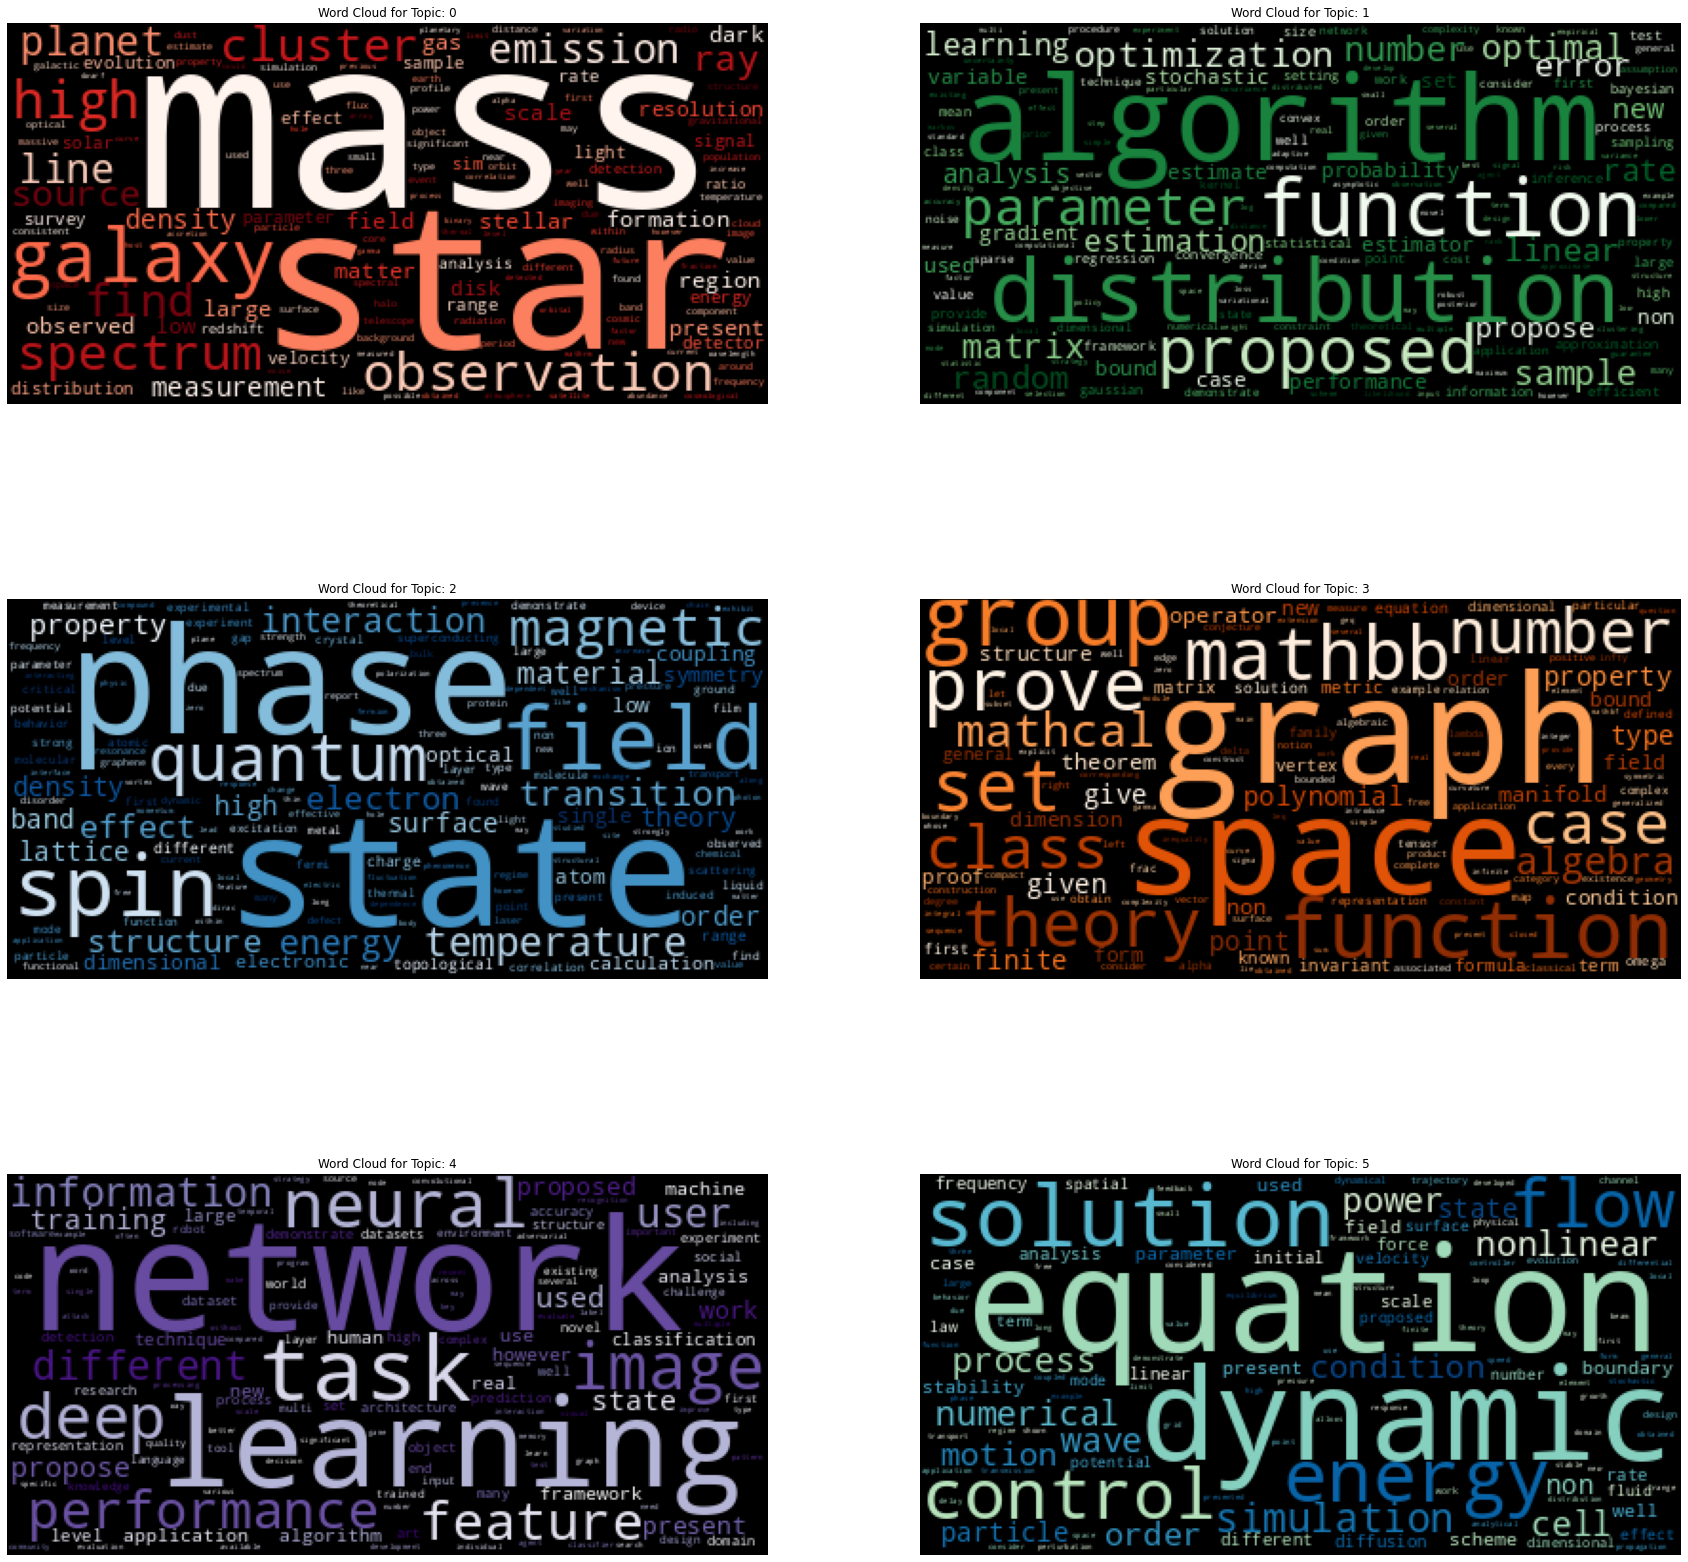

In [12]:
display_word_weighting(beta,dictionary)

We can clearly see that the model manages to capture 6 distinct topics that make sense in the context of research papers. Topic 0 could be labeled as **Astronomy** as it is characterized by words such as star, mass, galaxy, ray and planets. Topic 1 could both fall under the topic of **Computer Science**, characterized by words such as algorithm, function, parameter and optimization. Topic 4 is fairly similar to topic 1, though the words are more centered around **Neural Networks**. Topic 2 is characterized by words such as state, spin, phase, field and magnetic, thus it would be appropriate to give it the label **Magnetism**. Topic 3 is centered around **Mathematics** as it is characterized with words such as graph, function and mathematical latex notations. However, some of the highly characterizing words are terms that mainly fall into the field of group theory and discrete mathematics (group, space, set) which is something to take note of. Finally, topic 5 is characterized by words relating to **Thermodynamics** such as energy, flow, particle, dynamic and wave with some mathematical terms such as solution and equation mixed in the distribution aswell.

There are some obvious discrepencies when comparing the LDA topics to the ground thruth. For one, the finance and biology topics have been completely dropped by the LDA model, most likely due to the fact that there were very few papers about finance and biology in the dataset. When running these tests with highly reduced dataset, the model did in fact find underlying topics characterized by financial and biological terms (we'll discuss this more later). Instead of the finance and biology topics, the model seems to have found several subfields of physics (magnetism, thermodynamics and astronomy) instead of only having one physics topic like there was in the ground truth. The model has also found two topics relating to computer science, one being the 'Computer Science' topic and the other being the 'Neural Network' topic. Mathematics seems to be the only topic where the LDA model agrees with the ground truth, though the LDA mathematics topic is fairly focused on discrete mathematics.

We can further illustrate how the topics are related by classifying all the documents in the dataset and vizualizing them on a 2D plane through [t-SNE][1]. By analyzing the clusters, we can find out if and how the topics overlap and which topics are related to eachother.

[1]:[https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf]

In [13]:
topics = ['Astronomy', 'Computer Science', 'Magnetism', 'Mathematics', 'Neural Networks', 'Thermodynamics']
#topics = [x for x in range(K)]

The documents are classified by summing the probability of a word given a topic for each word in the document. The topic with the highest cumulative probability is declared the winner. 

The process of classifying a document:

$\max_{k\in K}P(d|z_k) = \max_{k\in K} \sum^{N_d}_{n}P(w_n|z_k) = \max_{k\in K}\sum^{N_d}_{n}\beta_{z_k,w_n}$

We decide to only plot a data point if the probability $P(d|z_k)$ for the majority topic exceeds 23%, this way only the high confidence predictions are showcased. This gives us an idea of how the model seperates the topics from each other.  To further illustrate the the grouping, confidence ellipses were plotted surrounding each cluster.

In [14]:
#source : https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, alpha=0.3,**kwargs)

    ax.add_artist(ellip)
    return ellip


In [15]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
import matplotlib.transforms as transforms
from scipy.spatial import ConvexHull
from scipy import interpolate
def run_cluster_plot(corpus,confidence_level=0.23,plot_ellipse=True):
    colors = ['red','green','blue','orange','purple','cyan','brown','grey','yellow','olive']
    doc_topics = np.ones((len(corpus)))*-1
    encoded_documents = np.zeros((len(corpus),len(dictionary)))
    indices = []
    for i,d in enumerate(corpus):
        try:
            s = np.sum(beta[:,d],axis=1)
            doc_topics[i] = np.argmax(s)
            if np.max(s) > confidence_level:
                indices.append(i)
        except:
            continue
    corpus = np.array(corpus)
    for v in range(len(dictionary)):
        encoded_documents[:,v] = np.array([(corpus[d] == v).sum() for d in range(len(corpus))])
    print("Number of high confidence documents:",len(indices))

    doc_colors = [colors[int(x)] for i,x in enumerate(doc_topics) if i in indices] 

    tsne = TSNE(n_components=2,perplexity=80,n_iter=2000,early_exaggeration=20,n_iter_without_progress=1000)
    transformed = tsne.fit_transform(encoded_documents[indices])
    fig, ax = plt.subplots(1, figsize=(10, 10))
    legends = []
    for i in range(K):
        topic_indices = np.where(np.array(doc_colors)==colors[i])[0]
        if plot_ellipse:
            plot_point_cov(transformed[topic_indices], ax=ax, nstd=2, facecolor=colors[i], edgecolor=colors[i])
        legends.append(mpatches.Patch(color=colors[i], label=topics[i]))    

    ax.scatter(transformed[:, 0], transformed[:, 1], color=doc_colors)
    plt.legend(handles=legends)
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of high confidence documents: 1033


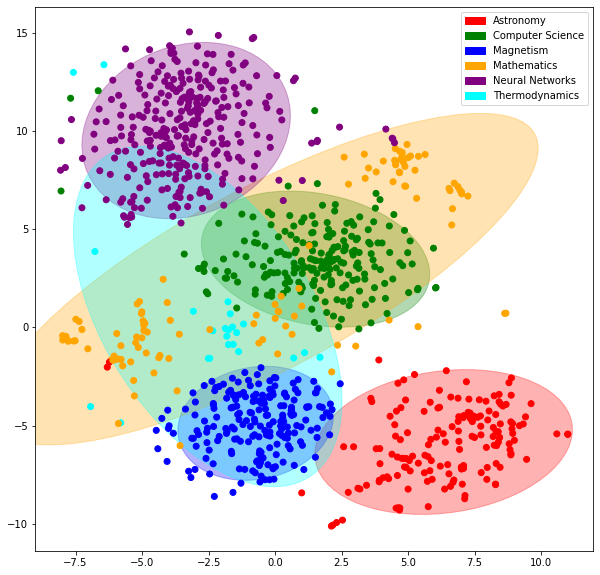

In [16]:
run_cluster_plot(corpus)

While most of the topics are well seperated, the mathematics cluster seems to overlap with several other topics. This reflects reality in a sense, as the fields of thermodynamics, magnetisism and computer science make heavy use of maths. The plot also shows that the computer science and neural network fields are fairly similar and that the astronomy topic is fairly independent, only being a little bit tied to magnetism. Finally, the model is not very confident when labeling documents by thermodynamics, showcased by the few amount of data points for said topic.

For a more qualitative idea on how documents look like for each generated topic, we could **list the documents that had the highest probability for each respective topic.**

In [19]:
doc_topic_prob = np.zeros((len(corpus),2))
documents_to_display = 5
pd.set_option('display.max_colwidth', None)

for i,d in enumerate(corpus):
    try:
        s = np.sum(beta[:,d],axis=1)
        doc_topic_prob[i,1] = np.argmax(s)
        doc_topic_prob[i,0] = np.max(s)
    except:
        doc_topic_prob[i,1] = -1
        doc_topic_prob[i,0] = 0
for k in range(6):
    doc_list = []
    indices = doc_topic_prob[doc_topic_prob[:,1]==k][:,0].argsort()[-documents_to_display:][::-1]
    doc_list = df.iloc[indices]['TITLE']
    init_df = {'Topic':[topics[int(i)] for i in doc_topic_prob[doc_topic_prob[:,1]==k][:,1][indices]],
            'Probability':doc_topic_prob[doc_topic_prob[:,1]==k][:,0][indices],
            'Title':doc_list
           }
    df_k = pd.DataFrame(init_df)
    display(df_k)


Topic  Probability  \
1095  Astronomy     0.420289   
550   Astronomy     0.418549   
586   Astronomy     0.401965   
996   Astronomy     0.392281   
917   Astronomy     0.384710   

                                                                Title  
1095  Invariant-based inverse engineering of crane control parameters  
550           Resting-state ASL : Toward an optimal sequence duration  
586                        Dynamics of cracks in disordered materials  
996                        A graph model of message passing processes  
917    WOMBAT: A Scalable and High Performance Astrophysical MHD Code

Topic  Probability  \
1488  Computer Science     0.444237   
2736  Computer Science     0.410070   
4295  Computer Science     0.381590   
4723  Computer Science     0.353359   
4982  Computer Science     0.352969   

                                                                                                  Title  
1488                                  Privacy-Preserving Deep Inference for Rich User Data on The Cloud  
2736                                                   Learning Effective Changes for Software Projects  
4295                                                            $0.7-2.5~μ$m spectra of Hilda asteroids  
4723  Interpretable High-Dimensional Inference Via Score Projection with an Application in Neuroimaging  
4982            Unsupervised Learning of Neural Networks to Explain Neural Networks (extended abstract)

Topic  Probability  \
1597  Magnetism     0.468066   
144   Magnetism     0.456893   
2680  Magnetism     0.441107   
1934  Magnetism     0.433137   
106   Magnetism     0.405710   

                                                                                                      Title  
1597              HNCcorr: A Novel Combinatorial Approach for Cell Identification in Calcium-Imaging Movies  
144   Concentration of weakly dependent Banach-valued sums and applications to statistical learning methods  
2680                                 Multi-Scale Pipeline for the Search of String-Induced CMB Anisotropies  
1934                                              Finite Sample Differentially Private Confidence Intervals  
106                                              Enumeration of singular varieties with tangency conditions

Topic  Probability  \
4208  Mathematics     0.381180   
2952  Mathematics     0.362984   
865   Mathematics     0.355031   
1339  Mathematics     0.331033   
1877  Mathematics     0.330135   

                                                                                               Title  
4208                                                 Polynomial Relations Between Matrices of Graphs  
2952  Metastability and avalanche dynamics in strongly-correlated gases with long-range interactions  
865    Speaker Diarization using Deep Recurrent Convolutional Neural Networks for Speaker Embeddings  
1339                                              Protein Folding and Machine Learning: Fundamentals  
1877                                                                    The Wisdom of a Kalman Crowd

Topic  Probability  \
2004  Neural Networks     0.536024   
2002  Neural Networks     0.524041   
3782  Neural Networks     0.491891   
350   Neural Networks     0.434114   
1601  Neural Networks     0.420218   

                                                                                               Title  
2004           Towards Understanding Generalization of Deep Learning: Perspective of Loss Landscapes  
2002  The role of industry, occupation, and location specific knowledge in the survival of new firms  
3782                                                     Analytic properties of approximate lattices  
350                                   The vortex method for 2D ideal flows in the exterior of a disk  
1601                                                          Mind the Gap: A Well Log Data Analysis

Topic  Probability  \
657   Thermodynamics     0.314462   
1712  Thermodynamics     0.312544   
88    Thermodynamics     0.288356   
1372  Thermodynamics     0.283161   
48    Thermodynamics     0.278552   

                                                                        Title  
657              Contextually Customized Video Summaries via Natural Language  
1712    Topology Estimation in Bulk Power Grids: Guarantees on Exact Recovery  
88    Photo-Chemically Directed Self-Assembly of Carbon Nanotubes on Surfaces  
1372                           Deep Learning the Ising Model Near Criticality  
48                          Attention-based Natural Language Person Retrieval

Listing the most popular documents for each topic and the confidence in the prediction from the model helps us understand the clustering a bit better. The first thing that stands out is that both mathematics and esepecially thermodynamics have low probabilities. A low probability essentially means that the model is not confident in labeling a document to a singular class. This was reflected in the t-SNE cluster plot earlier where the two clusters were somewhat intertwined. Interestingly enough, many machine learning and neural network terms appear in the titles of documents classified as non-neural network topics, especially for thermodynamics, mathematics and computer science. This also mirrors the t-SNE plot where those three clusters collided.

We know understand that documents are a mixture of topics, there are no cases where a topic makes up more than 50% of a document and in most cases, a singular topic does not even make up 23% of a topic as shown with in the t-SNE test. To further hit home this idea, one can shwocase the topic mixture for a document in the dataset by highlighting words corresponding to each topic.

In [101]:

idx = np.random.choice(range(len(corpus)))
doc = dictionary.doc2idx(df['BOW'][idx])
print(' '.join([colored(topics[i],c) for i,c in enumerate(colors[0:K])]))
print()
print(' '.join([colored(dictionary[w],colors[np.argmax(beta[:,w])]) if w>=0 else colored(df['BOW'][idx][i],'grey') for i,w in enumerate(doc)]))


Astronomy Computer Science Magnetism Mathematics Neural Networks Thermodynamics

consider optimal coverage problem multi agent network deployed environment obstacle maximize joint event detection probability objective function problem non convex global optimum guaranteed gradient based algorithm developed date first show objective function monotone submodular class function simple greedy algorithm known within optimal solution derive two tighter lower bound exploiting curvature information total curvature elemental curvature objective function show tightness lower bound complementary respect sensing capability agent greedy algorithm solution subsequently used initial point gradient based algorithm obtain solution even closer global optimum simulation result show approach lead significantly better performance relative previously used algorithm


#### Clustering on a balanced dataset

Let's explore how things change when we run the model on a smaller and more balanced dataset. For the previous experiment, we found that two topics of the ground truth, finance and biology, were lost in the LDA model. For this experiment, we set **$K=10$**

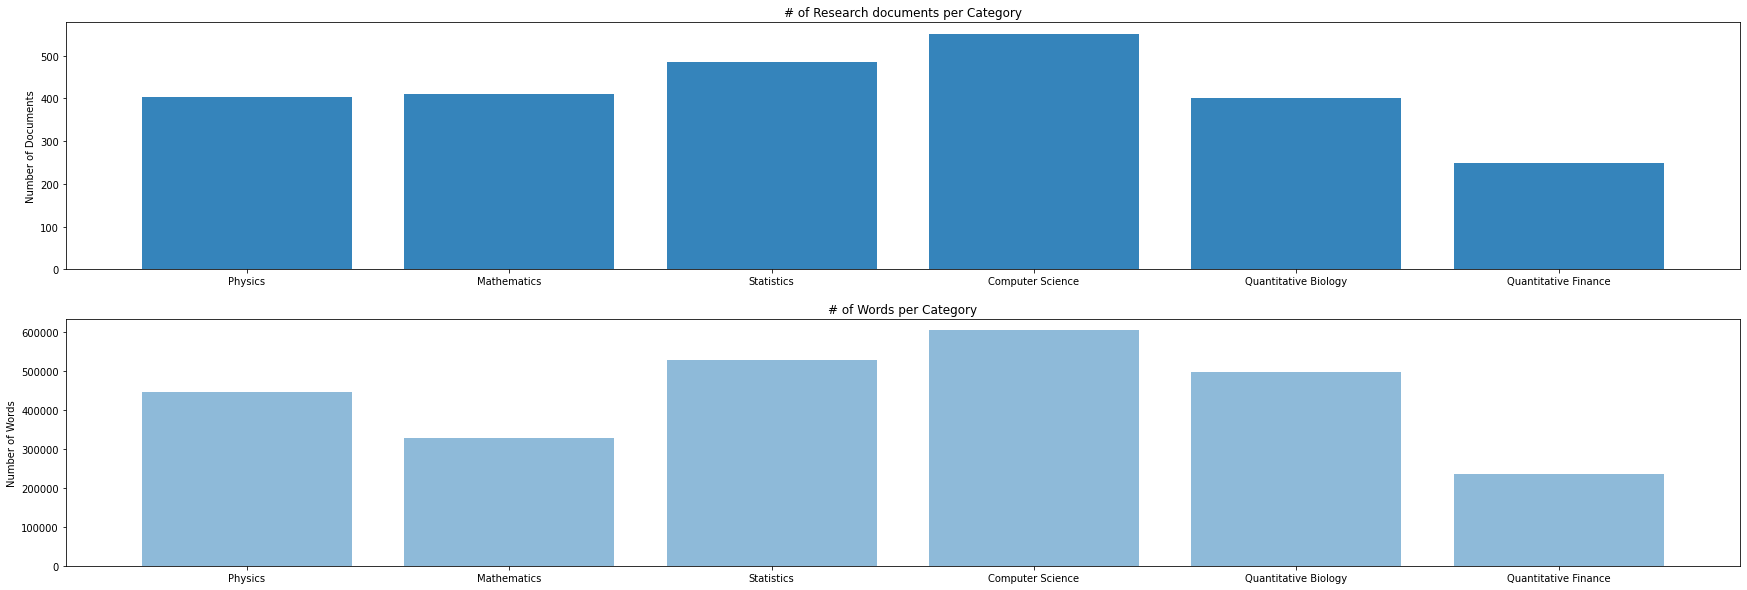

Amount of documents: 1972


In [23]:
df = pd.DataFrame(columns=data.columns)
for i,c in enumerate(classes):
    df = df.append(data.loc[data[c]==1][:REDUTION_SIZE]) #& ~df['ID'].isin(new_df['ID'])])
df = df.drop_duplicates(subset='ID')

class_count = []
word_count = []
for c in classes:
    class_count.append(df[c].value_counts()[[1]][1])
    class_abstracts = df.where(df[c]==1)[['ABSTRACT']]
    word_count.append(pd.Series(class_abstracts.values.flatten()).str.len().sum())

f, (ax1,ax2) = plt.subplots(2,1,figsize=(30,10))
ax1.bar(classes,class_count,align='center', alpha=0.9)
ax1.set_ylabel('Number of Documents')
ax2.bar(classes,word_count,align='center', alpha=0.5)
ax2.set_ylabel('Number of Words')
ax1.set_title('# of Research documents per Category')
ax2.set_title('# of Words per Category')
plt.show()

print("Amount of documents:", df.shape[0])

Topic 0     Topic 1      Topic 2     Topic 3        Topic 4  \
0        learning      market         cell    equation      algorithm   
1          neural       price      protein       state   optimization   
2            deep        risk  interaction    solution       proposed   
3            task       stock      dynamic     quantum       gradient   
4         feature   portfolio       effect         non       function   
5        training       asset   population  stochastic         kernel   
6           image     optimal      pattern     process           code   
7         machine  volatility        brain   numerical        present   
8     performance       agent       specie      scheme            new   
9  representation    strategy     activity   condition  computational   

       Topic 5       Topic 6   Topic 7      Topic 8      Topic 9  
0     analysis  distribution  function       energy         user  
1       effect        sample     group        field        graph  
2     research        matrix     space        phase         node  
3    different        random     prove        state    algorithm  
4       theory     parameter     graph     magnetic  application  
5  statistical          tree       set         spin  information  
6      provide     estimator     class  temperature   prediction  
7        value    estimation    finite      surface       design  
8  information      variable    mathbb      density        large  
9   population        number   mathcal    structure       attack

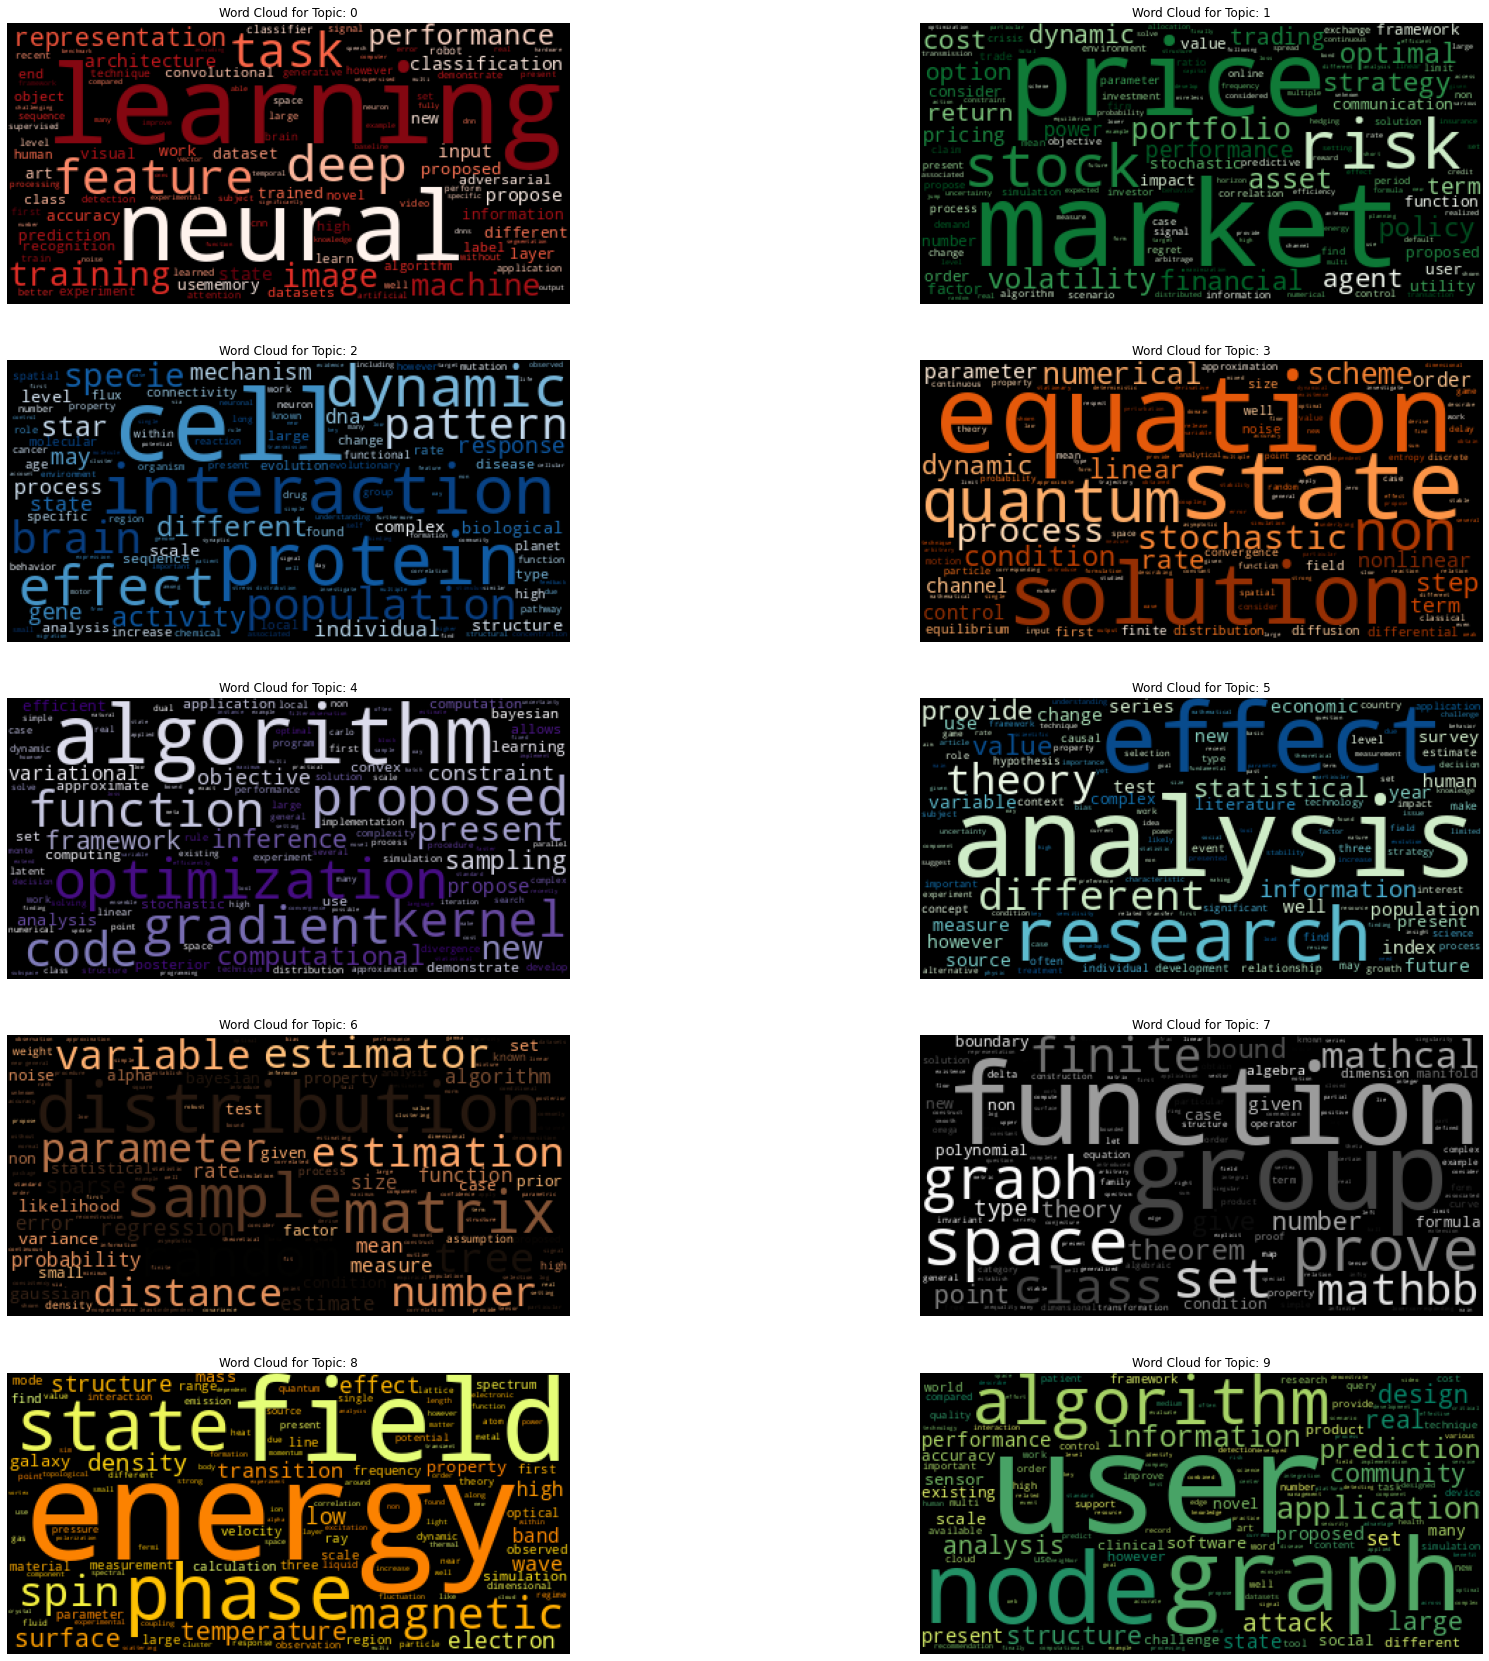

In [24]:
beta10 = np.load(model_path+"/b_k10.npy")
dictionary10 = dictionary.load(model_path+'/dictionary_k10')
display_word_weighting(beta10,dictionary10)

The topics for this models are fairly similar to earlier with the exceptions of topic 1 and 2 representing finance and biology respectively. This shows that LDA can struggle identifying underrepresented topics in a large collection of documents.